# Open Data Example

In this example, we consider [CMS open dataset](https://energyflow.network/docs/datasets/) for jets. At the particle level, we consider the sum of the leading and subleading jets as our observable. At the detector level, the observables include both the sum and the difference of the leading and subleading jets.

In [1]:
# Standard stuff
import numpy as np
import pandas as pd
import copy
import glob
from matplotlib import pyplot as plt


# Energy-flow package for CMS Open Data loader
import energyflow as ef
from energyflow.utils import remap_pids

# Pytorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

# POF functions
import utils
import profile_omnifold as pof

dvc = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {dvc} device")

2025-03-10 12:18:39.090372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 12:18:39.295668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 12:18:39.381866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 12:18:39.865911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 12:18:43.541376: W tensorflow/compiler/tf2

Using cuda device


## Load and Generate Data

In [20]:
# specify the nuisance parameter
theta = 1.2

In [3]:
def load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, x_dim = 3, momentum_scale = 250, n = 100000, amount = 1, max_particle_select = None, frac = 1.0):

    # Load data
    specs = [f'{pt_lower} <= gen_jet_pts <= {pt_upper}', f'abs_gen_jet_eta < {eta}', f'quality >= {quality}']
    # specs = [f'{pt_lower} <= jet_pts <= {pt_upper}', f'abs_jet_eta < {eta}', f'quality >= {quality}']
    sim = ef.mod.load(*specs, cache_dir = cache_dir, dataset='sim', amount= amount, store_gens = False, subdatasets=['SIM600_Jet300_pT375-infGeV'])

    # Gen_pt for Y
    Y1 = sim.jets_f[:,sim.gen_jet_pt]
    Y = np.zeros((Y1.shape[0], 1), dtype = np.float32 )
    Y[:,0] = Y1 / momentum_scale

    # Sim_pt for X
    X = np.zeros((Y1.shape[0],3), dtype = np.float32)
    event_ids = np.zeros((Y1.shape[0],1), dtype = np.int32)
    X[:,0] = sim.jets_f[:,sim.jet_pt] / momentum_scale
    X[:,1] = sim.jets_f[:,sim.jet_eta]
    X[:,2] = sim.jets_f[:,sim.jet_phi]
    event_ids = sim.jets_i[:,sim.evn]

    Y = Y[:n]
    X = X[:n]
    event_ids = event_ids[:n]

    # Trim and shuffle
    if max_particle_select is not None:
        dataset = dataset[particle_counts < max_particle_select]
        Y = Y[particle_counts < max_particle_select]
        X = X[particle_counts < max_particle_select]

    print("X: ", X.shape, X.dtype)
    print("Y: ", Y.shape, Y.dtype)

    return X, Y, event_ids

In [4]:
y_dim = 1
x_dim = 3



# Dataset Parameters
cache_dir = "/global/cfs/projectdirs/m3246/bnachman/.energyflow"
momentum_scale = 1000
n = 100000
pad = 150
pt_lower, pt_upper = 500, 1000
eta = 2.4
quality = 2

# #############################
# ########## DATASET ##########
# #############################

X, Y, ids = load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, momentum_scale = momentum_scale, n = n, max_particle_select = None, amount = 1)
X_test, Y_test, ids_test = load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, momentum_scale = momentum_scale, n = 50)


X:  (94237, 3) float32
Y:  (94237, 1) float32
X:  (50, 3) float32
Y:  (50, 1) float32


In [5]:
sorted = np.sort(ids)
sorted_indices = ids.argsort()
print(ids.shape)
print(sorted)


counter = 0
pairs = []
N = len(sorted)
for (i,id) in enumerate(sorted):
    for (j, id2) in enumerate(sorted[(i+1):]):

        if id == id2:
            counter += 1
            pairs.append((i, i+1+j))
            break

        if id2 > id:
            break

print(counter / N )

(94237,)
[   3673    3673    3674 ... 3980015 3980016 3980016]
0.4657618557466812


In [6]:

sorted_gen_pts = Y[sorted_indices]
sorted_sim_pts = X[sorted_indices,0]

leading_gen_pts = []
subleading_gen_pts = []
leading_sim_pts = []
subleading_sim_pts = []

for pair in pairs:

    jet1 = sorted_gen_pts[pair[0]]
    jet2 = sorted_gen_pts[pair[1]]

    sim_jet1 = sorted_sim_pts[pair[0]]
    sim_jet2 = sorted_sim_pts[pair[1]]

    leading_gen_pts.append(jet2)
    subleading_gen_pts.append(jet1)
    leading_sim_pts.append(sim_jet2)
    subleading_sim_pts.append(sim_jet1)

    '''
    if jet1 > jet2:
        leading_gen_pts.append(jet1)
        subleading_gen_pts.append(jet2)
        leading_sim_pts.append(sim_jet1)
        subleading_sim_pts.append(sim_jet2)
    else:
        leading_gen_pts.append(jet2)
        subleading_gen_pts.append(jet1)
        leading_sim_pts.append(sim_jet2)
        subleading_sim_pts.append(sim_jet1)
    '''

leading_gen_pts = np.array(leading_gen_pts)[:,0]
subleading_gen_pts = np.array(subleading_gen_pts)[:,0]

leading_sim_pts = np.array(leading_sim_pts)
subleading_sim_pts = np.array(subleading_sim_pts)

### Experimental Data (Nature)

In [21]:
x_data = leading_gen_pts + subleading_gen_pts
x_data = x_data.reshape(-1,1).astype(np.float64)

In [22]:
leading_sim_pts_hold = leading_gen_pts + theta*(leading_sim_pts - leading_gen_pts)
subleading_sim_pts_hold = subleading_gen_pts + theta*(subleading_sim_pts-subleading_gen_pts)
y_data = np.c_[leading_sim_pts_hold + subleading_sim_pts_hold, leading_sim_pts_hold - subleading_sim_pts_hold]

### Monte Carlo Data (Simulation)

In [9]:
def weight_func(x):
    return x[0]*np.exp(x[0])

weights = np.apply_along_axis(weight_func, axis=1, arr=x_data)

# Normalize weights
weights /= np.sum(weights)

# Perform weighted sampling
N_mc = len(x_data)  # Number of samples to draw
idx = np.random.choice(np.arange(len(x_data)), size=N_mc, replace=True, p=weights)

In [10]:
x_mc = leading_gen_pts[idx] + subleading_gen_pts[idx]
x_mc = x_mc.reshape(-1,1).astype(np.float64)
y_mc = np.c_[leading_sim_pts[idx] + subleading_sim_pts[idx], leading_sim_pts[idx] - subleading_sim_pts[idx]].astype(np.float64)

### Systematic Data (varying theta, used for training W function)

In [11]:
theta_min = 0.8
theta_max = 1.8
N_sys = x_mc.shape[0]

theta0_sim = np.random.uniform(theta_min, theta_max, N_mc).reshape(-1,1)
theta1_sim = np.random.uniform(theta_min, theta_max, N_sys).reshape(-1,1)

In [12]:
leading_sim_pts_hold = leading_gen_pts + theta1_sim[:,0]*(leading_sim_pts - leading_gen_pts)
subleading_sim_pts_hold = subleading_gen_pts + theta1_sim[:,0]*(subleading_sim_pts-subleading_gen_pts)
y_sys = np.c_[leading_sim_pts_hold + subleading_sim_pts_hold, leading_sim_pts_hold - subleading_sim_pts_hold]

## Train W model

We train a neural network (NN) model to learn the W function, which represents the ratio of the response kernel parametrized by $\theta$ to the Monte Carlo (MC) kernel, i.e. $w(y,x,\theta)=p(y|x,\theta)/q(y|x)$.

In [13]:
# hyperparameters for training the neural network
config = {
    'batch_size': 10000,
    'lr': 0.001,
    'patience': 30,
    'activation': nn.ReLU()
}

In [28]:
w_ds = pof.w_dataset(x_mc, y_mc, theta0_sim, x_data, x_sys, theta1_sim)

w_ds_train, w_ds_test = random_split(w_ds, [len(w_ds)//2, len(w_ds)-len(w_ds)//2])
w_dataloader_train = DataLoader(w_ds_train, batch_size=10000, shuffle=True, num_workers=0)
w_dataloader_test = DataLoader(w_ds_test, batch_size=10000, shuffle=False, num_workers=0)

In [29]:
# Train W model

wRT_model_network = pof.wRT_network(sigmoid=True, n_inputs=4, activation=config['activation']).double().to(dvc)
optimizerRT = optim.Adam(wRT_model_network.parameters(), lr=config['lr'])
loss_fn_RT = nn.BCELoss()
wRT_tr = pof.w_trainer(w_dataloader_train, w_dataloader_test, wRT_model_network, loss_fn_RT, optimizerRT, patience=config['patience'])

wT_model_network = pof.wT_network(sigmoid=True, n_inputs=2, activation=config['activation']).double().to(dvc)
optimizerT = optim.Adam(wT_model_network.parameters(), lr=config['lr'])
loss_fn_T = nn.BCELoss()
wT_tr = pof.w_trainer(w_dataloader_train, w_dataloader_test, wT_model_network, loss_fn_T, optimizerT)

wRT_tr.fit()
wT_tr.fit()

===================== Model W =====================
wRT_network(
  (linear_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (activation_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): ReLU()
    (batchNorm_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W =====================
wT_network(
  (linear_stack): Sequential(
    (linear_0): Linear(in_features=2, out_features=50, bias=True)
    (activation_0): ReL

In [ ]:
# load the models if saved previously
wRT_model_network = pof.wRT_network(sigmoid=True, n_inputs=4).double().to(dvc)
wT_model_network = pof.wT_network(sigmoid=True, n_inputs=2).double().to(dvc)

wRT_model_network.load_state_dict(torch.load("models/OpenData/wRT_network_2dgaussian.pth")["model_state_dict"])
wT_model_network.load_state_dict(torch.load("models/OpenData/wT_network_2dgaussian.pth")["model_state_dict"])

In [14]:
# load the ensemble of models
wRT_list = glob.glob("models/OpenData/Ensemble_exclude_x2/wRT_network_x1exp(x1)_thetamin=0.8_thetamax=2.5(*)")
wT_list = glob.glob("models/OpenData/Ensemble_exclude_x2/wT_network_x1exp(x1)_thetamin=0.8_thetamax=2.5(*)")

wRT_ensemble = []
wT_ensemble = []
for i in range(len(wRT_list)):
    wRT_ensemble.append(pof.wRT_network(sigmoid=True, activation=config['activation'], n_inputs=4).double().to(dvc))
    wT_ensemble.append(pof.wT_network(sigmoid=True, activation=config['activation'], n_inputs=2).double().to(dvc))
    wRT_ensemble[i].load_state_dict(torch.load(wRT_list[i]))
    wT_ensemble[i].load_state_dict(torch.load(wT_list[i]))

In [15]:
# wrap the w function on the MC dataset (so that it becomes only a function of theta)
ds = pof.test_dataset(x_mc, y_mc)
ds_dataloader = DataLoader(ds, batch_size=100000, shuffle=False)
#w_theta_nn = pof.make_w_theta(ds_dataloader, wRT_model_network, wT_model_network)
w_theta_nn_ensemble = pof.make_w_theta_ensemble(ds_dataloader, wRT_ensemble, wT_ensemble, func='median')

## Profile OmniFold Algorithm

Now, let's run the algorithm! There are two options:  

1. **Gradient-Based Approach** – This version requires computing the gradient of the w function with respect to $\theta$.  
2. **Grid Search Approach** – This version does not require the gradient but instead performs a grid search over $\theta$ to find the optimum.  

When $\theta$ is low-dimensional, the **grid search approach** may be preferred.  

In [16]:
# use the NN fitted w function
w_theta = w_theta_nn_ensemble
#w_theta_grad = w_theta_nn_grad

In [ ]:
# gradient-based approach
nu_pof = pof.profile_omnifold(y_data, x_mc, y_mc, w_theta, w_theta_grad, theta_bar=1.0, theta0=1.0, no_penalty=True, theta_range=[0.5,2.0])

In [23]:
# no gradient approach
nu_pof = pof.profile_omnifold_no_grad(y_data, x_mc, y_mc, 10, w_theta, theta_bar=1.0, theta0=1.3, theta_range=[1.0,2.0], num_grid_points=30,
                                               no_penalty=True, verbose=0)

fitting w on grid points...
Initial Theta: 1.3

ITERATION: 1

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

STEP 3

Value of Theta before update: 1.3
Updated value of Theta: 1.3448275862068966

ITERATION: 2

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

STEP 3

Value of Theta before update: 1.3448275862068966
Updated value of Theta: 1.3793103448275863

ITERATION: 3

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step 

STEP 3

Value of Theta before update: 1.3793103448275863
Updated value of Theta: 1.3793103448275863

ITERATION: 4

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 

STEP 3

Value of Theta before update: 1.3793103448275863
Updated value of Theta: 1.3793103448275863

ITERATION: 5

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

STEP 3

Value

In [25]:
# As comparison, we can also run the vanilla omnifold algorithm
nu_of = pof.omnifold(y_data, x_mc, y_mc, 10, verbose=0)


ITERATION: 1

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 

ITERATION: 2

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

ITERATION: 3

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

ITERATION: 4

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 

ITERATION: 5

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

ITERATION: 6

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step 

ITERATION: 7

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 

ITERATION: 8

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 

ITERATION: 9

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 

ITERATION

### Plot the results

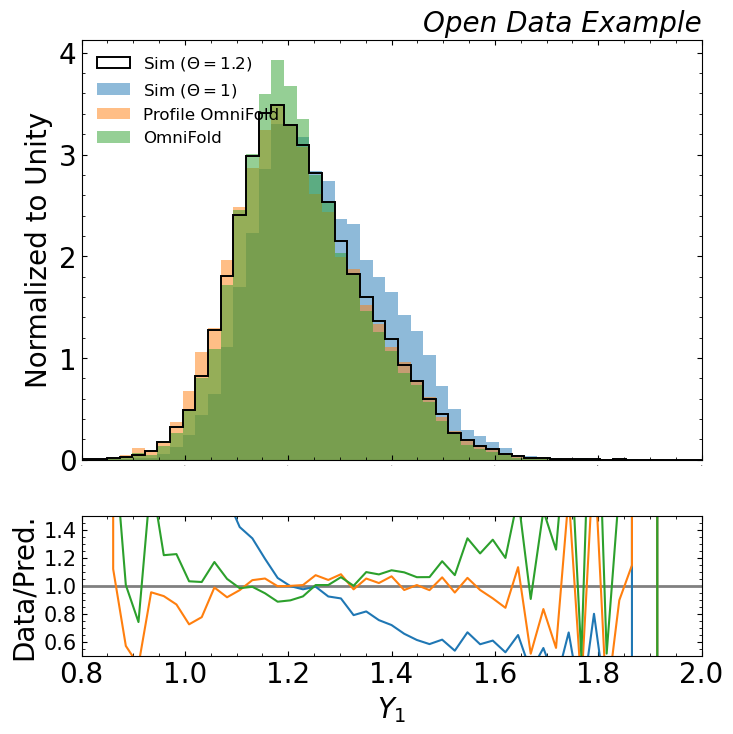

<Figure size 640x480 with 0 Axes>

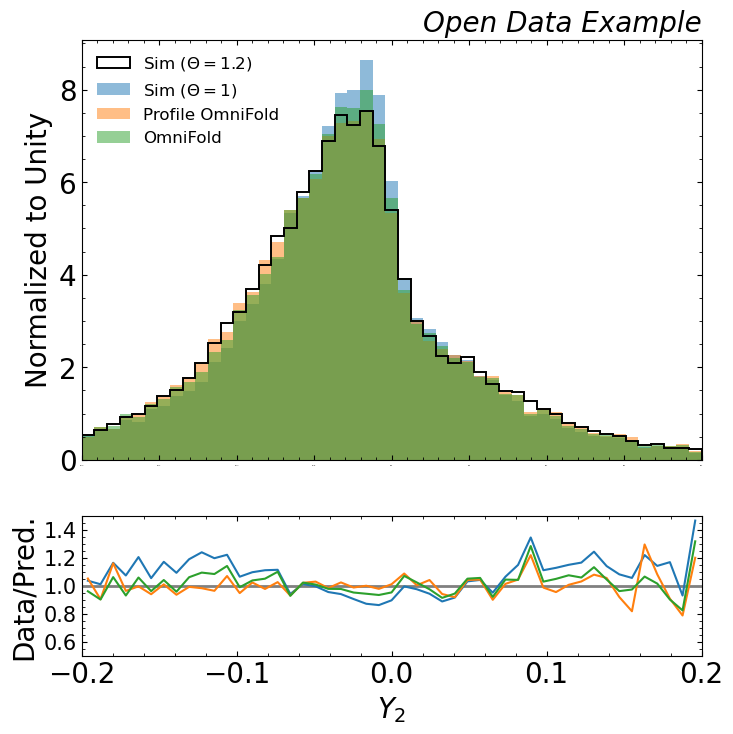

<Figure size 640x480 with 0 Axes>

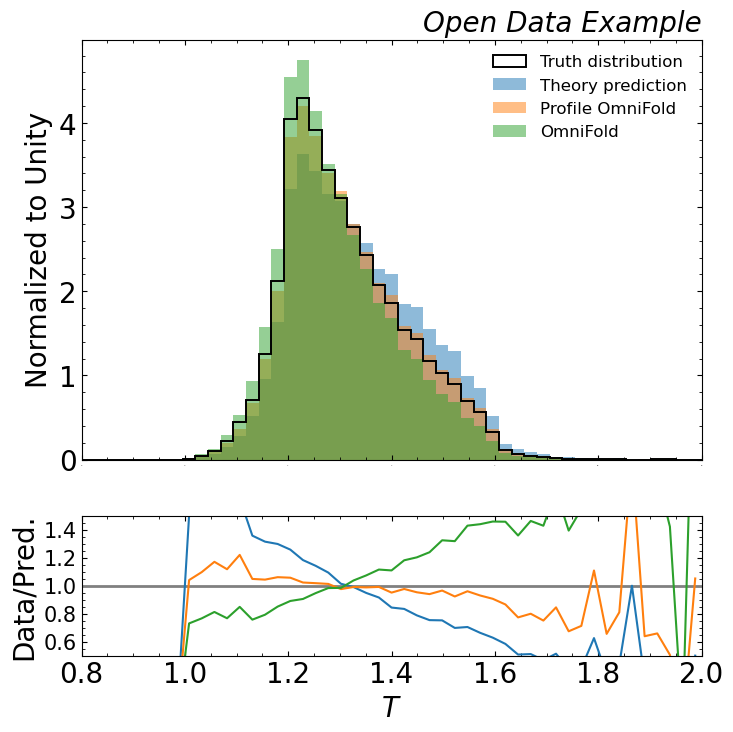

fitted theta: 1.3793103448275863


<Figure size 640x480 with 0 Axes>

In [26]:
# indicate which iteration to plot
i = 9

cpwr = utils.comparison_plots_with_ratio(0.8, 2.0, 50, xlabel=r"$Y_1$", density=True, header="Open Data Example")
cpwr.add_data(y_data[:,0], label=f"Sim ($\Theta={theta}$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(y_mc[:,0], label=r"Sim ($\Theta=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(y_mc[:,0], weights=nu_pof[i,0,:]*nu_pof[i,2,:], label="Profile OmniFold", alpha=0.5, color='tab:orange')
cpwr.add_data(y_mc[:,0], weights=nu_of[i,0,:], label="OmniFold", alpha=0.5, color='tab:green')
cpwr.show()

cpwr = utils.comparison_plots_with_ratio(-0.2, 0.2, 50, xlabel=r"$Y_2$", density=True, header="Open Data Example")
cpwr.add_data(y_data[:,1], label=f"Sim ($\Theta={theta}$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(y_mc[:,1], label=r"Sim ($\Theta=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(y_mc[:,1], weights=nu_pof[i,0,:]*nu_pof[i,2,:], label="Profile OmniFold", alpha=0.5, color='tab:orange')
cpwr.add_data(y_mc[:,1], weights=nu_of[i,0,:], label="OmniFold", alpha=0.5, color='tab:green')
cpwr.show()

cpwr = utils.comparison_plots_with_ratio(0.8, 2.0, 50, xlabel=r"$T$", density=True, legend_corner="upper right", header="Open Data Example")
cpwr.add_data(x_data, label="Truth distribution", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(x_mc, label="Theory prediction", alpha=0.5, color='tab:blue')
cpwr.add_data(x_mc, weights=nu_pof[i,1,:], label="Profile OmniFold", alpha=0.5, color='tab:orange')
cpwr.add_data(x_mc, weights=nu_of[i,1,:], label="OmniFold", alpha=0.5, color='tab:green')
cpwr.show()

print('fitted theta:', nu_pof[i,3,0])